In [309]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
import time
from PIL import Image
import itertools

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Natural Language processing
import nltk

## Stemming
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

# Learning Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Process
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import Pipeline

# Corpus
from documentModel import DocumentModel as DM
from export_results import *

In [331]:
def save_image(image, url='../images/', name = 'default'):
    image.savefig(url + name)
    Image.open(url + name + '.png').convert('L').save(url + name + '.png')
    
def plot_image(x, y, title="title", ylim = [0, 1.02], xlim = [2, 50.5], 
               colors="rgbmyc", models=None, name="name", labels=[], ylabel = "ylabel", 
               loc="better", markers=".,ov<>", pattern=""):
    plt.figure(figsize=(14,13))
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel("Misclassification Cost Ratio")
    plt.ylabel(ylabel)
    
    plt.style.use('paper.mplstyle')
    
    i = 0
    for model in models:
        name = model[0]
        if pattern in name:
            plt.plot(x, y[name])
            plt.scatter(x, y[name], marker=markers[i], s=300, label=model[0])
            i+=1
    
    plt.xticks(x, labels, rotation='vertical')
    plt.legend(loc=loc, prop={'size':30})

    save_image(plt,'../images/', name)
    plt.show()
    
def filter_results(recalls, precisions, models=None, pattern=""):

    recalls_avg = {}
    precisions_avg = {}
    
    for model in models:
        name = model[0]
        if pattern in model[0]:
            recalls_avg[name] = recalls[name]
            precisions_avg[name] = precisions[name]
    
    return recalls_avg, precisions_avg
    
def normalize(recall_avg, precision_avg):
    recall_avg_normalized = {}

    for key, value in recall_avg.items():
        recall_avg_normalized[key] = []

    for key, values in recall_avg.items():
        for value in values:
            recall_avg_normalized[key].append(float(value * 100))
 

    precision_avg_normalized = {}

    for key, value in precision_avg.items():
        precision_avg_normalized[key] = []

    for key, values in precision_avg.items():
        for value in values:
            precision_avg_normalized[key].append(float(value * 100))    
    return recall_avg_normalized, precision_avg_normalized

def set_baseline(name):
    recall_baseline = recall_avg_normalized[name]
    precision_baseline = precision_avg_normalized[name]
    
    return recall_baseline, precision_baseline

In [289]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer(language="spanish")
    
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [306]:
def init():
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    pipelines = []

    for element in itertools.product(estimators, nlp):
        name = element[1][0] + '_' + element[0][0]
        pipeline = Pipeline([('nlp', element[1][1]), ('clf', element[0][1])])
        pipelines.append((name , pipeline))
        recall_avg[name] = []
        precision_avg[name] = []
        recall_std[name] = []
        precision_std[name] = []
        
    return pipelines, recall_avg, recall_std , precision_avg, precision_std

# Business Rule Classification

In [197]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


## NLP Exploration

In [198]:
rule_data = pd.DataFrame({"rule": X, "tag": y})
permissions = rule_data[rule_data["tag"] == 0]
prohibitions = rule_data[rule_data["tag"] == 1]

In [199]:
permissions.head()

,rule,tag
0,Aplicar sobre el suelo en pequeños montones o ...,0
3,"Aplicar en pulverización normal, variando la d...",0
4,En la etiqueta deberán figurar las instruccion...,0
9,"Aplicar en pulverización normal, dependiendo d...",0
14,Aplicar en pulverización normal,0


In [200]:
prohibitions.head()

,rule,tag
1,Evitar que el producto caiga sobre las plantas...,1
2,Advertir en la etiqueta que es peligroso para ...,1
5,No mezclar con aceites ni productos de reacció...,1
6,No aplicar aceites minerales durante los 21 dí...,1
7,No aplicar en cultivos cuyos frutos sean desti...,1


## Experiment Variables

In [313]:
labels = ["1:1","1:2","1:4","1:6","1:10","1:25", "1:50", r"1:$10^2$", r"1:$10^3$", r"1:$10^6$"]
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedKFold(y, n_folds = 10, random_state = 2016)
costs = np.array([2, 3, 4, 6, 10, 25, 50, 100, 1000, 1000000])
axis_costs = np.arange(1,11,1)
cxlim = [0.8, 10.15]
estimators = [("Naive Bayes", MultinomialNB(fit_prior=False)), 
              ("Random Forest", RandomForestClassifier(n_estimators=20)), 
              ("SVM", SVC(kernel='linear', C = 0.1)),
              ("Baseline", DummyClassifier(strategy = "constant", constant=1))]

nlp = [("None", TfidfVectorizer(use_idf = True, stop_words=stop_words)),
       ("Stemming", TfidfVectorizer(use_idf = True, stop_words=stop_words, tokenizer=LemmaTokenizer())), 
       ("Bigrams", TfidfVectorizer(use_idf = True, stop_words=stop_words, ngram_range=(2, 2))), 
       ("Combination", TfidfVectorizer(use_idf = True, stop_words=stop_words, ngram_range=(1, 2)))]

## Main Experiment Loop

In [314]:
t0 = time.time()
pipes, recall_avg, recall_std, precision_avg, precision_std = init()

for estimator in pipes:
    name = estimator[0]
    print("Trying: " + name + " ...")
    for cost in costs:
        extractor = estimator[1].steps[0][1].fit(X)
        if "Naive Bayes" in name:
            model = estimator[1].set_params(clf__class_prior=[1/cost, (cost-1)/cost]).steps[1][1]
        elif "Random Forest" in name:
            model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
        elif "SVM" in name:
            model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
        elif "Baseline" in name:
            model = estimator[1].steps[1][1]
            
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = \
                extractor.transform(X)[train_index], extractor.transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[name].append(np.average(recalls))
        recall_std[name].append(np.std(recalls))
        precision_avg[name].append(np.average(precisions))
        precision_std[name].append(np.std(precisions))

recall_avg_normalized, precision_avg_normalized = normalize(recall_avg, precision_avg)        
t1 = time.time()
print()
print("Execution time: %.3f min" % ((t1 - t0)/60))

None_Naive Bayes
Stemming_Naive Bayes
Bigrams_Naive Bayes
Combination_Naive Bayes
None_Random Forest
Stemming_Random Forest
Bigrams_Random Forest
Combination_Random Forest
None_SVM
Stemming_SVM
Bigrams_SVM
Combination_SVM
None_Baseline
Stemming_Baseline
Bigrams_Baseline
Combination_Baseline
Execution time: 10.394 min


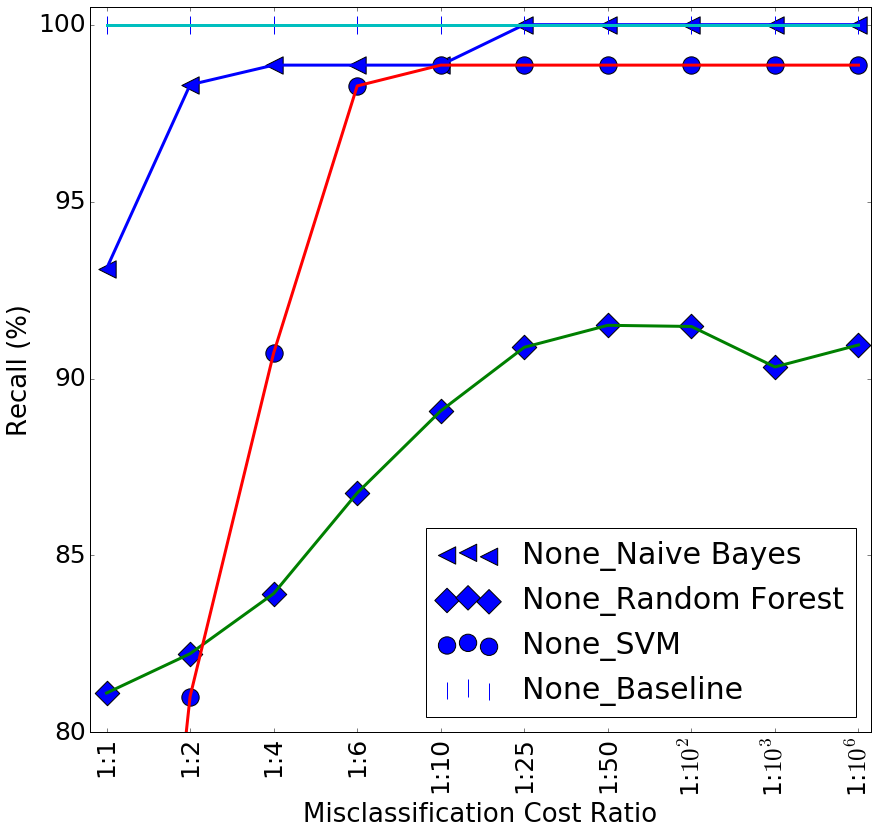

In [332]:
plot_image(axis_costs, recall_avg_normalized, title="RECALL", ylim = [80., 100.5], 
           xlim = cxlim, models=pipes, name="recall", labels=labels, ylabel="Recall (%)", 
           loc='lower righ', markers="<Do|", pattern="None")

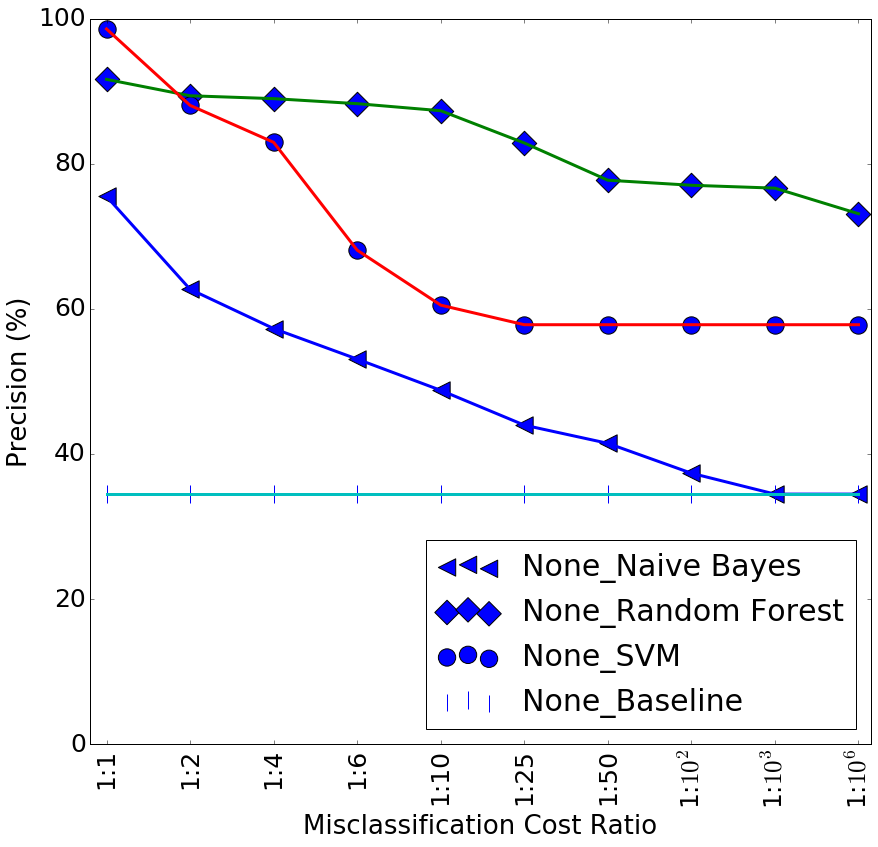

In [336]:
plot_image(axis_costs, precision_avg_normalized, title="PRECISION", ylim = [0., 100], 
           xlim = cxlim, colors="rgbmyc", models=pipes, name="precision", labels = labels, ylabel="Precision (%)",
           loc ="lower right", markers="<Do|", pattern="None")

## Stemming

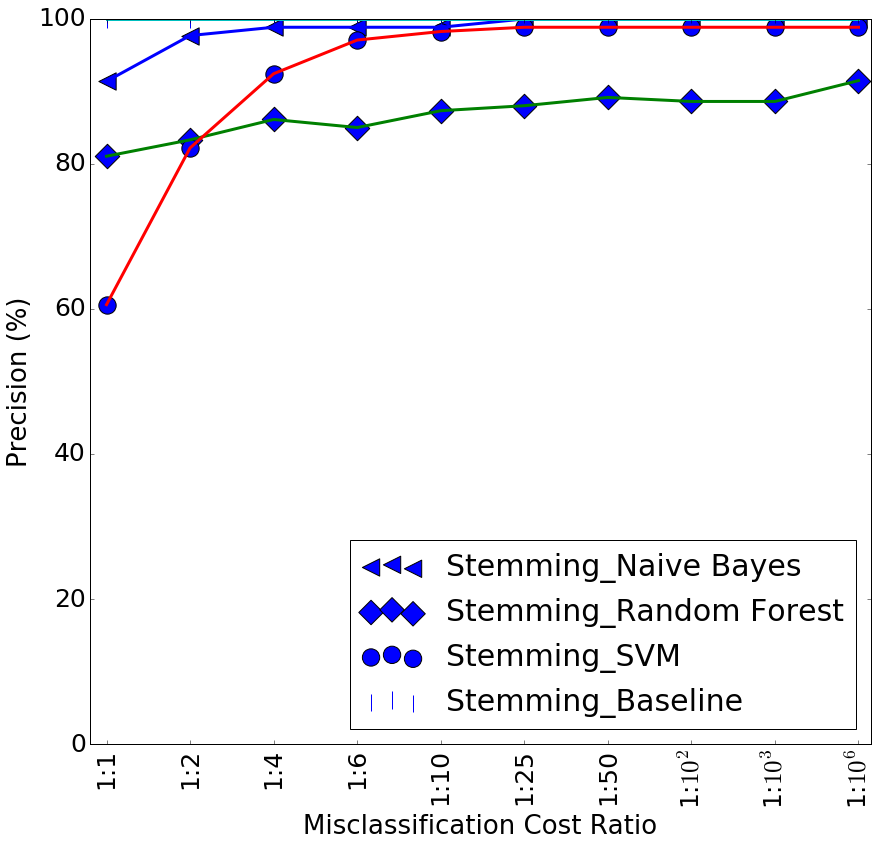

In [338]:
plot_image(axis_costs, recall_avg_normalized, title="RECALL", ylim = [0., 100], 
           xlim = cxlim, colors="rgbmyc", models=pipes, name="recall_bayes", labels = labels, ylabel="Precision (%)",
           loc ="lower right", markers="<Do|", pattern="Stemming")

## Word sequences

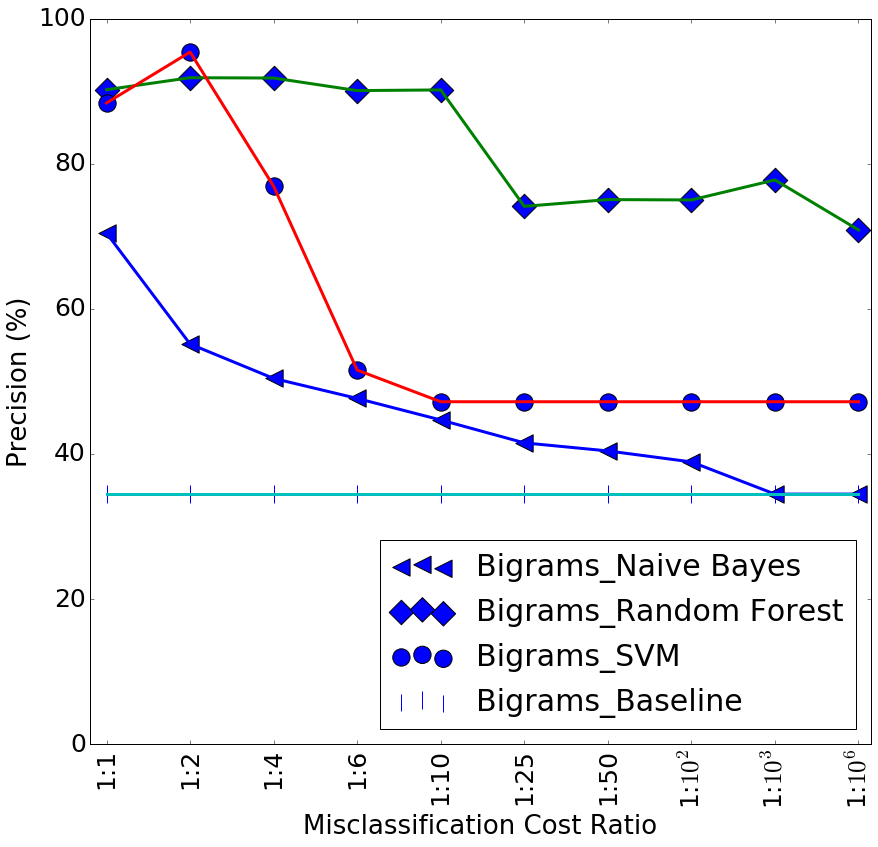

In [339]:
plot_image(axis_costs, precision_avg_normalized, title="PRECISION", ylim = [0., 100], 
           xlim = cxlim, colors="rgbmyc", models=pipes, name="precision", labels = labels, ylabel="Precision (%)",
           loc ="lower right", markers="<Do|", pattern="Bigrams")